# Feature Engineering Notebook

## Objectives

* Pre-process the images in a one-hot encoding.
* Use powerful pre-trained neural networks to extract complex features from the dataset of dog images for breed classification, specifically:
    - InceptionV3
    - Xception
    - InceptionResNetV2
    - NASNetLarge
* Concatenate all of the 4 extracted features into a single feature map.

## Inputs

* labels.csv
* images/train/
* breed_dict.pkl
* breeds.pkl

## Outputs

* final_features.pkl
* y.pkl


---

# Importing all the packages / libraries we need

In [1]:
import os
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img
from keras.utils import to_categorical
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
from keras.layers import Lambda
from keras.layers import Input
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.xception import Xception, preprocess_input
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.applications.nasnet import NASNetLarge, preprocess_input
import pickle
import time
import gc

/tmp/ipykernel_38972/2243817900.py:3: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
2024-05-08 15:25:45.695909: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-08 15:25:45.696091: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-08 15:25:45.697947: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-08 15:25:45.719661: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the foll

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
current_dir = os.getcwd()
current_dir

'/home/jaaz/Desktop/project-5/TailTeller/jupyter_notebooks'

We want to make the parent of the current directory the new current directory.
* os.path.dirname() gets the parent directory
* os.chdir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("New current directory:", os.getcwd())

New current directory: /home/jaaz/Desktop/project-5/TailTeller


---

# Pre-process and Encode

We will create a function to pre-process (transform the data before feeding it to the algorithm) the images and labels to encode them into a numpy array in a one-hot encoded format.

In [4]:
# Load the breed dictionary
with open('breed_dict.pkl', 'rb') as f:
    breed_dict = pickle.load(f)

input_shape = (299,299,3)

def images_to_array(directory, label_dataframe, target_size = input_shape):
    image_labels = label_dataframe['breed']
    # Using uint8 will save RAM memory when tackling large amounts of data
    images = np.zeros([len(label_dataframe), target_size[0], target_size[1], target_size[2]], dtype=np.uint8)
    y = np.zeros([len(label_dataframe), 1], dtype=np.uint8)

    """
    Taking each index and image name, constructing
    A full path of each image, loading them and resizing,
    Storing images into the array, deleting images to save RAM
    """
    for ix, image_name in enumerate(tqdm(label_dataframe['id'].values)):
        img_dir = os.path.join(directory, image_name + '.jpg')
        img = load_img(img_dir, target_size = target_size)
        images[ix] = img
        del img

        # Getting the breed label for the current image
        # And convert the breed name into a numerical
        # Index and assign it to a label array "y"
        dog_breed = image_labels[ix]
        y[ix] = breed_dict[dog_breed]
    
    # Convert the vector class into a binary matrix (one-hot encoding)
    y = to_categorical(y)

    return images,y

We will now use the images_to_array() function to our train/ folder, giving 'x' the features (in this case, the images) and 'y' the labels.

In [5]:
labels = pd.read_csv('labels.csv')

# Get a list of all image file names in the 'images/train/' directory
image_files = os.listdir('images/train/')

# Remove the file extension from image file names
image_names = [os.path.splitext(file)[0] for file in image_files]

# Filter the labels to only include those that have a corresponding image
labels = labels[labels['id'].isin(image_names)]

# Reset the index of the labels DataFrame
labels.reset_index(drop=True, inplace=True)

t = time.time()

x, y = images_to_array('images/train/', labels)
print('runtime in seconds: {}'.format(time.time() - t))

with open('y.pkl', 'wb') as f:
    pickle.dump(y, f)

100%|██████████| 5111/5111 [00:03<00:00, 1507.51it/s]

runtime in seconds: 3.392303943634033


Now we can display the some images along with their corresponding breed titles in a grid plot.

We can see that all images have the same exact size, and their corresponding breed label on top:

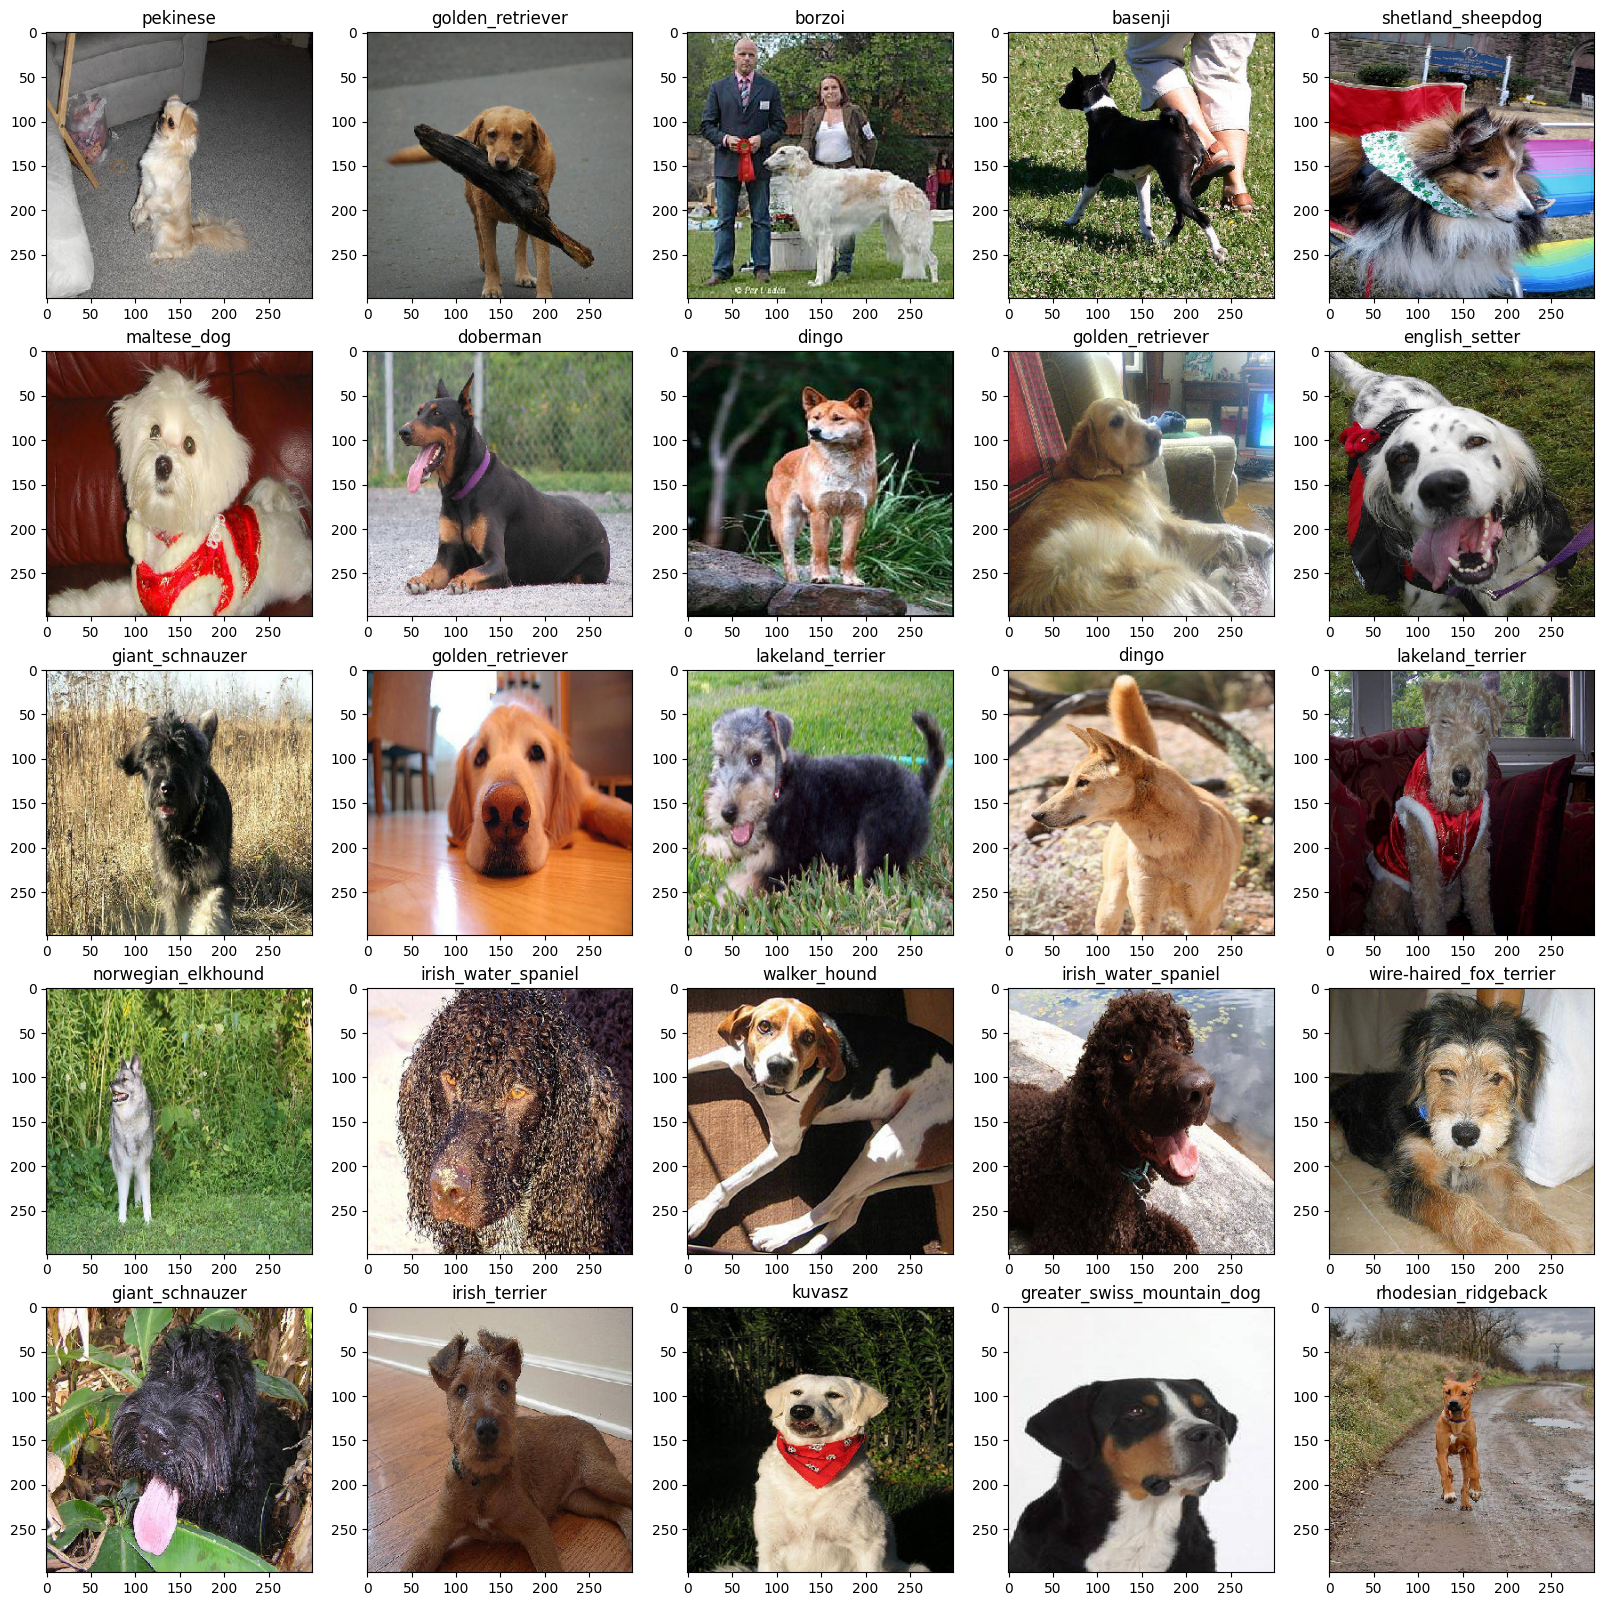

In [6]:
# Load breed name titles with pickle
with open('breeds.pkl', 'rb') as f:
    breeds = pickle.load(f)

n=25

plt.figure(figsize=(20,20))

for i in range(n):
    ax = plt.subplot(5,5,i+1)
    plt.title(breeds[np.where(y[i]==1)[0][0]])
    plt.imshow(x[i].astype('int32'))

# Use Neural Networks

The main idea is to implement pre-trained models and extract meaningful features from the dataset. Tese extracted features will be integrated into a simple and effective deep neural network.

To achieve this, we'll apply GlobalAveragePooling2D to generate a pooled output from the chosen models. The variable img_size will be adjusted according to the input size requirements of the chosen pre-trained models. This ensures that our data is appropriately shaped for feature extraction.

For detailed specifications about the models, refer to the Keras [models](https://keras.io/api/applications/) documentation.

In [7]:
#function to extract features from the dataset by a given pretrained model
img_size = (299,299,3)

def get_features(model_name, model_preprocessor, input_size, data):

    input_layer = Input(input_size)
    preprocessor = Lambda(model_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    
    #Extract feature
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

### These pre-trained models have been trained on the 'ImageNet' dataset, which contain over 1,2 million images with 1000 categories.

# InceptionV3
* lightweight but performs very well on a wide range of tasks.

In [ ]:
# Extract features using InceptionV3
inception_preprocessor = preprocess_input
inception_features = get_features(InceptionV3,
                                  inception_preprocessor,
                                  img_size, x)

# Xception
* Based on the concept of separable convolutions which makes it more efficient than standard convolutional layers.

In [ ]:
# Extract features using Xception 
xception_preprocessor = preprocess_input
xception_features = get_features(Xception,
                                 xception_preprocessor,
                                 img_size, x)

# InceptionResNetV2
* Combines the benefits of the Inception architecture with residual connections which can help to alleviate the vanishing gradient problem in deep networks.

In [ ]:
# Extract features using InceptionResNetV2 
inc_resnet_preprocessor = preprocess_input
inc_resnet_features = get_features(InceptionResNetV2,
                                   inc_resnet_preprocessor,
                                   img_size, x)

# NASNetLarge
* Automated process that can discover the best network architecture for a given task, this optimizes our model for high performance.

In [ ]:
# Extract features using NASNetLarge 
nasnet_preprocessor = preprocess_input
nasnet_features = get_features(NASNetLarge,
                               nasnet_preprocessor,
                               img_size, x)

### Concatenate features extracted from our multiple pre-trained models into a single feature map.

In [ ]:
final_features = np.concatenate([
    inception_features,
    xception_features,
    nasnet_features,
    inc_resnet_features
], axis=-1)  # axis=-1 indicates that concatenation is along the last dimension

### Let's save the final_features variable with pickle, we will use this variable to build our model.

In [ ]:
with open('final_features.pkl', 'wb') as f:
    pickle.dump(final_features, f)

# Output the shape of the combined final feature map
print('Final feature maps shape:', final_features.shape)

Now that we have the file we want, it's always good practice to free up the RAM memory from such heavy variables

In [ ]:
#Free up RAM memory

del inception_features
del xception_features
del nasnet_features
del inc_resnet_features
del final_features
gc.collect()

# Conclusions and Next steps

The Feature Engineering Notebook has effectively pre-processed the dataset and utilized a series of sophisticated pre-trained neural networks to extract high-dimensional feature sets from a dataset of dog images (train/ folder). These features have been successfully concatenated into a single comprehensive feature map, setting a robust foundation for building a predictive model. This preparation ensures that the subsequent model will have a rich dataset to learn from, potentially improving its accuracy and generalization when classifying dog breeds.

## Next steps:

- Callbacks Setup

    * Monitoring Callbacks: Use callbacks to save model at various stages during training.
    * Learning Rate Adjustment: Implement a reducing method to adjust the learning rate when a plateau in model performance is detected, which helps fine-tuning it.

- Hyperparameter Tuning

    * Select Hyperparameters: Define key hyperparameters such as learning rate, epochs and batch size.
    * Optimization Algorithm: Implement an additional optimization algorithm to help with training our model.

- Model Development

    * Model Architecture: Design and build a neural network using the Sequential model from Keras.

- Model Training

    * Train the Model: With the architecture and hypermarameters set, we begin trainnig the model using teh combined feature map as input.

---